In [2]:
import asyncio
import aiohttp
import nest_asyncio
import pandas as pd
from understat import Understat
import numpy as np

nest_asyncio.apply()

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

async def xG_flow(team_name, season):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        print(f"Searching for {team_name} matches in {season}")
        
        try:
            result= await understat.get_team_results(team_name, season)
            return result
        except Exception as e:
            print(f"An error occured: {e}")
            return []
        
target_team=input("Enter the name of the tean (e.g., Liverpool, Arsenal): ")
target_season=input("Enter Season Year (e.g., 2024, 2025): ")
            
match_data= asyncio.run(xG_flow(target_team, target_season))    

df_matches = pd.DataFrame(match_data)    

df_matches = df_matches[df_matches["goals"].apply(lambda x: x is not None)]

df_matches["opponent"] = np.where(
    df_matches["side"]=="h",
    df_matches["a"].apply(lambda x: x["title"]),
    df_matches["h"].apply(lambda x: x["title"])
)

df_matches["result"]=df_matches.apply(
    lambda row: str(row["goals"]["h"] + "-" + str(row["goals"]["a"])), axis=1
)

print(f"\n --->MATCH LIST FOR {target_team.upper()}<---")
display_cols=["id", "datetime", "opponent", "result", "side"]
print(df_matches[display_cols].tail(10).to_string(index=False))

    


Searching for Liverpool matches in 2019

 --->MATCH LIST FOR LIVERPOOL<---
   id            datetime         opponent result side
11928 2020-03-07 12:30:00      Bournemouth    2-1    h
11940 2020-06-21 18:00:00          Everton    0-0    a
11951 2020-06-24 19:15:00   Crystal Palace    4-0    h
11959 2020-07-02 19:15:00  Manchester City    4-0    a
11966 2020-07-05 15:30:00      Aston Villa    2-0    h
11976 2020-07-08 19:15:00         Brighton    1-3    a
11986 2020-07-11 14:00:00          Burnley    1-1    h
11993 2020-07-15 19:15:00          Arsenal    2-1    a
12006 2020-07-22 19:15:00          Chelsea    5-3    h
12016 2020-07-26 15:00:00 Newcastle United    1-3    a


In [3]:
match_id=input("Paste the Match Id here: ")

async def get_shot_info(match_id):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        
        shots=await understat.get_match_shots(match_id)
        return shots
    
shot_data=asyncio.run(get_shot_info(match_id))

df_home=pd.DataFrame(shot_data["h"])
df_away=pd.DataFrame(shot_data["a"])

def clean_df(df):
    cols=["X", "Y", "xG", "minute"]
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

df_home=clean_df(df_home)
df_away=clean_df(df_away)

home_team_name=df_home["h_team"].iloc[0]
away_team_name=df_home["a_team"].iloc[0]

if home_team_name == target_team:
    my_team_df = df_home
    opp_df = df_away
    opp_name = away_team_name
    my_side = "Home"
else:
    my_team_df = df_away
    opp_df = df_home
    opp_name = home_team_name
    my_side = "Away"

print(f"Data Loaded: {target_team} ({my_side} vs {opp_name})")
print(f"Data Loaded \n Home Shots: {len(df_home)} | Away Shots: {len(df_away)}")
df_home.head(3)

Data Loaded: Liverpool (Away vs Arsenal)
Data Loaded 
 Home Shots: 3 | Away Shots: 24


,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,371632,31,Goal,0.938,0.385,0.646486,Alexandre Lacazette,h,3277,OpenPlay,2019,RightFoot,11993,Arsenal,Liverpool,2,1,2020-07-15 19:15:00,None,TakeOn
1,371635,43,Goal,0.892,0.419,0.361562,Reiss Nelson,h,6492,OpenPlay,2019,RightFoot,11993,Arsenal,Liverpool,2,1,2020-07-15 19:15:00,Alexandre Lacazette,Pass
2,371653,89,MissedShots,0.853,0.496,0.307111,Joe Willock,h,6630,OpenPlay,2019,RightFoot,11993,Arsenal,Liverpool,2,1,2020-07-15 19:15:00,Pierre-Emerick Aubameyang,Chipped


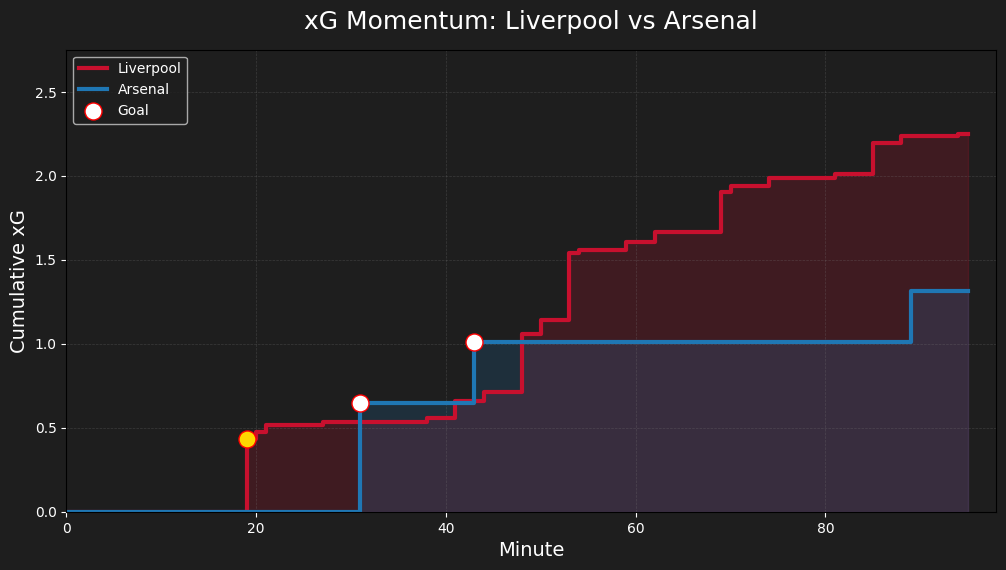

In [10]:
import matplotlib.pyplot as plt
import numpy as np

my_team_df = my_team_df.sort_values(by="minute")
my_team_df["xG_cumsum"] = my_team_df["xG"].cumsum()

opp_df = opp_df.sort_values(by="minute")
opp_df["xG_cumsum"] = opp_df["xG"].cumsum()
    
def get_flow_data(df):
    
    minutes = [0]+df["minute"].tolist()
    xg_flow=[0]+df["xG_cumsum"].tolist()
    
    last_min=max(minutes[-1], 95)
    minutes.append(last_min)
    xg_flow.append(xg_flow[-1])
    
    return minutes, xg_flow

my_mins, my_flow=get_flow_data(my_team_df)
opp_mins, opp_flow=get_flow_data(opp_df)

fig, ax=plt.subplots(figsize=(12, 6))
fig.set_facecolor("#1e1e1e")
ax.set_facecolor("#1e1e1e")

ax.step(my_mins, my_flow, where="post", color="#c8102e", linewidth=3, label=target_team)
ax.step(opp_mins, opp_flow, where="post", color="#1f77b4",linewidth=3, label=opp_name)

ax.fill_between(my_mins, my_flow, step="post", color="#c8102e", alpha=0.2)
ax.fill_between(opp_mins, opp_flow, step="post", color="#1f77b4", alpha=0.2)

my_goals=my_team_df[my_team_df["result"]=="Goal"]
opp_goal=opp_df[opp_df["result"]=="Goal"]

for _, row in my_goals.iterrows():
    ax.scatter(row["minute"], row["xG_cumsum"], s=150, color="gold", edgecolors="red",zorder=10, label="Goal")
    
for _, row in opp_goal.iterrows():
    ax.scatter(row["minute"], row["xG_cumsum"], s=150, color="white", edgecolors="red",zorder=10, label="Goal")
    
max_xg=max(my_flow[-1], opp_flow[-1])
ax.set_ylim(0, max_xg+0.5)
ax.set_xlim(0, 98)

ax.set_xlabel("Minute", fontsize=14, color="white")
ax.set_ylabel("Cumulative xG", fontsize=14, color="white")
ax.set_title(f"xG Momentum: {target_team} vs {opp_name}", fontsize=18, color="white", pad=15)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # Dictionary removes duplicates
ax.legend(by_label.values(), by_label.keys(), loc='upper left', facecolor='#1e1e1e', labelcolor='white')

plt.show()